In [15]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
import sksurv as sks
from sksurv.datasets import load_gbsg2
from sksurv.nonparametric import kaplan_meier_estimator#
from lifelines import CoxPHFitter
warnings.filterwarnings("ignore")

In [16]:
X,Y = load_gbsg2()
print(X.columns)

Index(['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade',
       'tsize'],
      dtype='object')


In [17]:
censoring = []
time = []
for delta, t in Y:
    censoring.append(delta)
    time.append(t)

In [18]:
gbsg2 = X.copy()
gbsg2['time'] = time
gbsg2['censoring'] = censoring

In [19]:
gbsg2.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize,time,censoring
0,70.0,66.0,no,Post,3.0,48.0,II,21.0,1814.0,True
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0,2018.0,True
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0,712.0,True
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0,1807.0,True
4,73.0,65.0,no,Post,1.0,26.0,II,35.0,772.0,True


In [20]:
gbsg2.describe()

,age,estrec,pnodes,progrec,tsize,time
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,53.052478,96.252187,5.010204,109.995627,29.329446,1124.489796
std,10.120739,153.083963,5.475483,202.331552,14.296217,642.791948
min,21.000000,0.000000,1.000000,0.000000,3.000000,8.000000
25%,46.000000,8.000000,1.000000,7.000000,20.000000,567.750000
50%,53.000000,36.000000,3.000000,32.500000,25.000000,1084.000000
75%,61.000000,114.000000,7.000000,131.750000,35.000000,1684.750000
max,80.000000,1144.000000,51.000000,2380.000000,120.000000,2659.000000


In [21]:
gbsg2['tgrade']

0       II
1       II
2       II
3       II
4       II
      ... 
681    III
682    III
683    III
684     II
685     II
Name: tgrade, Length: 686, dtype: category
Categories (3, object): ['I', 'II', 'III']

In [22]:
#for col in data.columns:
#    print(np.unique(data[col]))
gbsg2['horTh'] = gbsg2['horTh'].replace({'yes': 1, 'no': 0})
gbsg2['menostat'] = gbsg2['menostat'].replace({'Post': 1, 'Pre': 0})
gbsg2['tgrade'] = gbsg2['tgrade'].replace({'I': 1, 'II': 2, 'III': 3 })
gbsg2['censoring'] = gbsg2['censoring'].replace({True: 1, False: 0})
gbsg2.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize,time,censoring
0,70.0,66.0,0,1,3.0,48.0,2,21.0,1814.0,1
1,56.0,77.0,1,1,7.0,61.0,2,12.0,2018.0,1
2,58.0,271.0,1,1,9.0,52.0,2,35.0,712.0,1
3,59.0,29.0,1,1,4.0,60.0,2,17.0,1807.0,1
4,73.0,65.0,0,1,1.0,26.0,2,35.0,772.0,1


In [23]:
gbsg2['ER'] = 0
gbsg2['ER'][gbsg2['estrec'] >= 20] = 1

gbsg2['PR'] = 0
gbsg2['PR'][gbsg2['progrec'] >= 20] = 1

gbsg2.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize,time,censoring,ER,PR
0,70.0,66.0,0,1,3.0,48.0,2,21.0,1814.0,1,1,1
1,56.0,77.0,1,1,7.0,61.0,2,12.0,2018.0,1,1,1
2,58.0,271.0,1,1,9.0,52.0,2,35.0,712.0,1,1,1
3,59.0,29.0,1,1,4.0,60.0,2,17.0,1807.0,1,1,1
4,73.0,65.0,0,1,1.0,26.0,2,35.0,772.0,1,1,1


In [25]:
gbsg2.drop(columns=["estrec", "progrec"])


,age,horTh,menostat,pnodes,tgrade,tsize,time,censoring,ER,PR
0,70.0,0,1,3.0,2,21.0,1814.0,1,1,1
1,56.0,1,1,7.0,2,12.0,2018.0,1,1,1
2,58.0,1,1,9.0,2,35.0,712.0,1,1,1
3,59.0,1,1,4.0,2,17.0,1807.0,1,1,1
4,73.0,0,1,1.0,2,35.0,772.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
681,49.0,0,0,3.0,3,30.0,721.0,0,1,0
682,53.0,1,1,17.0,3,25.0,186.0,0,0,0
683,51.0,0,0,5.0,3,25.0,769.0,1,0,1
684,52.0,0,1,3.0,2,23.0,727.0,1,1,0


In [26]:
gbsg2 = gbsg2[['time','censoring','age','ER','horTh','menostat','pnodes','PR','tgrade','tsize']]
gbsg2.head()

,time,censoring,age,ER,horTh,menostat,pnodes,PR,tgrade,tsize
0,1814.0,1,70.0,1,0,1,3.0,1,2,21.0
1,2018.0,1,56.0,1,1,1,7.0,1,2,12.0
2,712.0,1,58.0,1,1,1,9.0,1,2,35.0
3,1807.0,1,59.0,1,1,1,4.0,1,2,17.0
4,772.0,1,73.0,1,0,1,1.0,1,2,35.0


In [28]:
dataset_name = "gbsg2_test_encoding"
data_file= "./dataset/" + dataset_name + "/data.csv"
gbsg2.to_csv(data_file,header=False,index=False)

In [31]:
from utils import data_processing, visualization, statistic



feat_types_file = "./dataset/" + dataset_name + "/data_types.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "./dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

In [32]:
# Load training data
data, feat_types_dict, miss_mask, true_miss_mask, n_samples = data_processing.read_data(data_file, feat_types_file, miss_file, true_miss_file)


In [33]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'name': 'ER', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'horTh', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'menostat', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'pnodes', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'PR', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'tgrade', 'type': 'cat', 'dim': '1', 'nclass': '3'},
 {'name': 'tsize', 'type': 'pos', 'dim': '1', 'nclass': ''}]

survcens
age
ER
horTh
menostat
pnodes
PR
tgrade
tsize


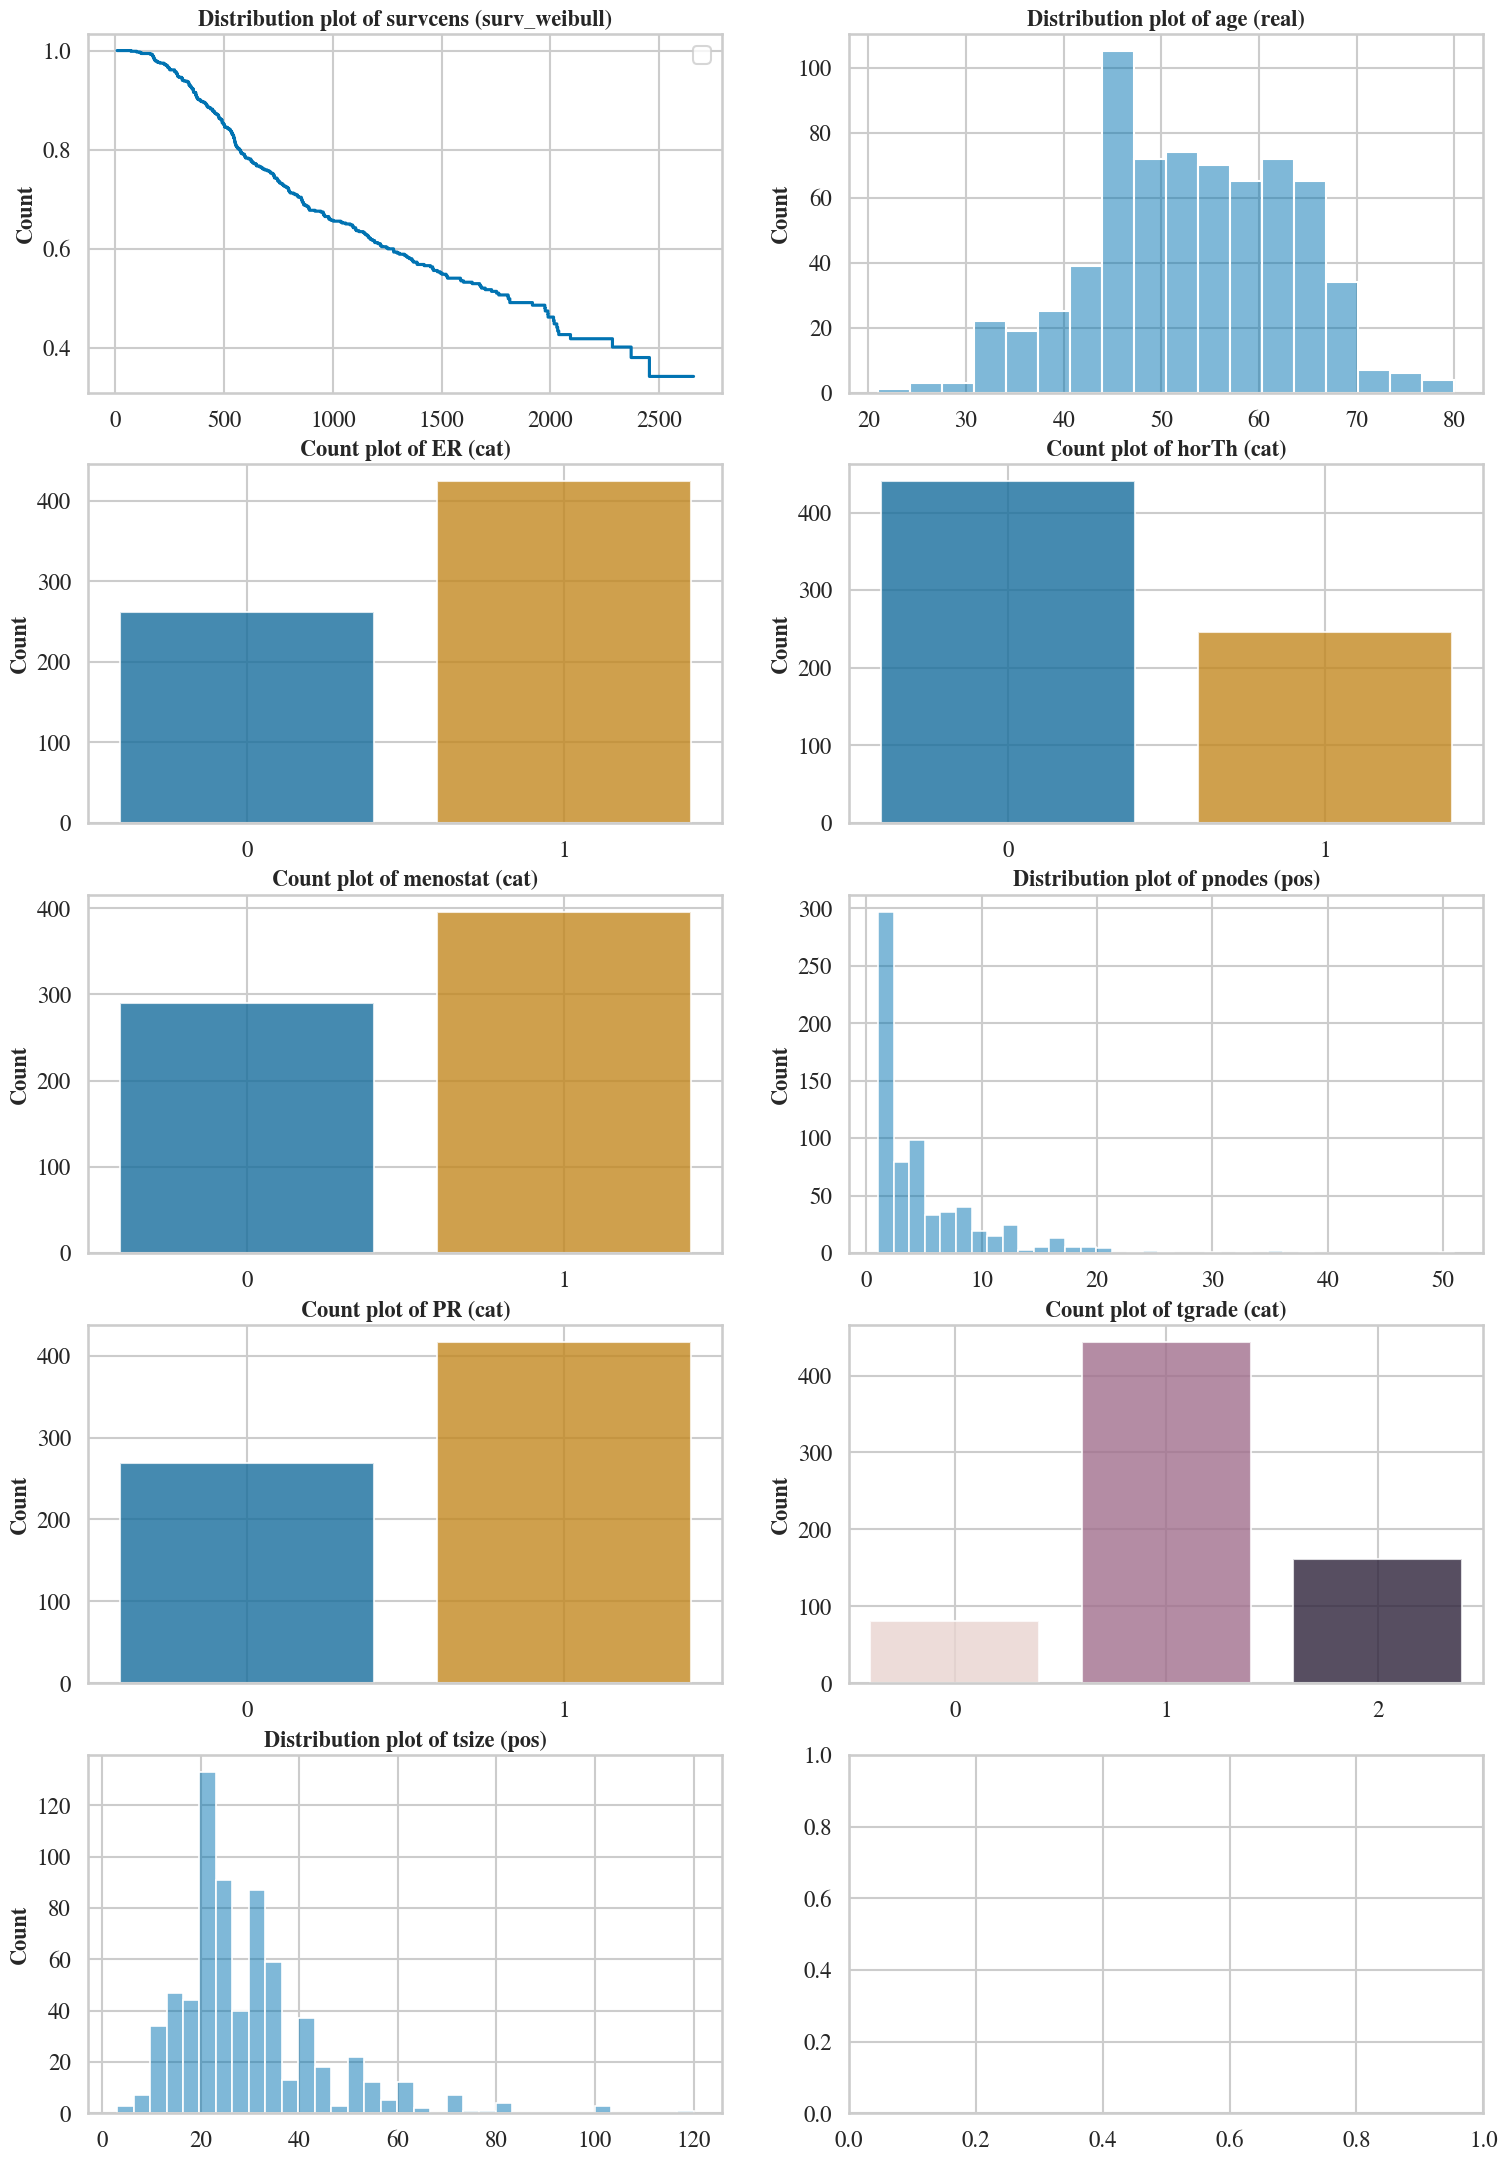

In [34]:
# Feature analysis
data_transformed = data_processing.discrete_variables_transformation(data, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed, feat_types_dict)

comparison variable horTh 4


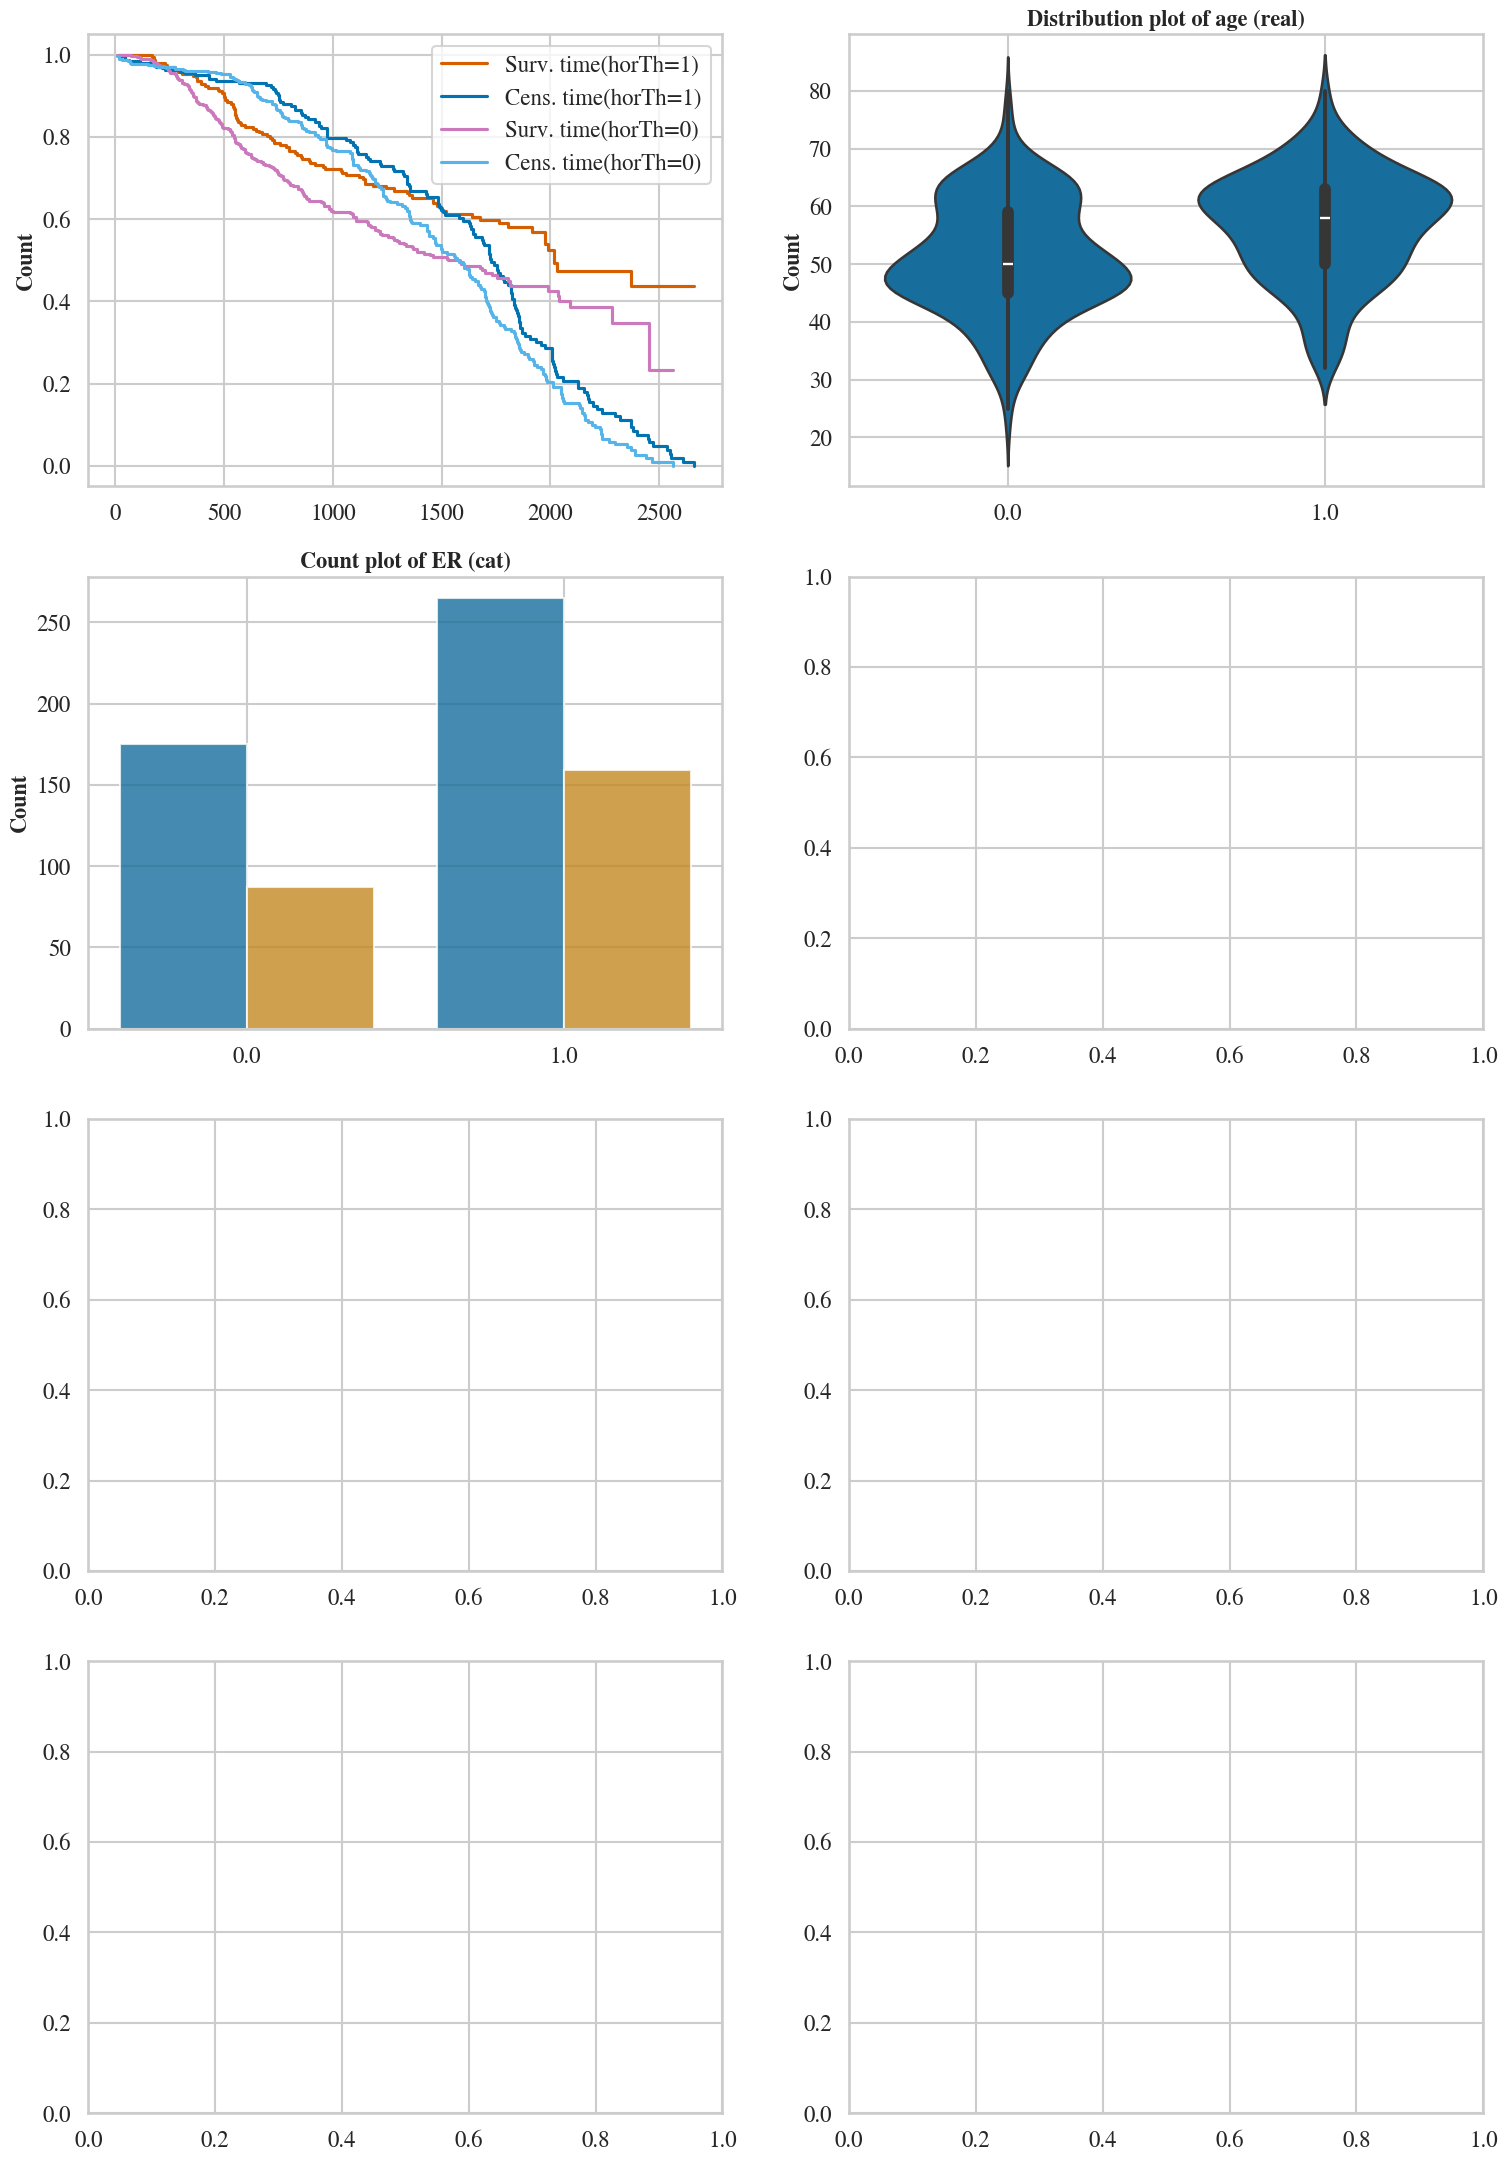

In [35]:
visualization.plot_compare_data(data_transformed, feat_types_dict,feat_comparison_name = 'horTh')

In [36]:
gbsg2_treated = gbsg2[gbsg2['horTh']==1].drop(["horTh"] , axis =1)
gbsg2_control = gbsg2[gbsg2['horTh']==0].drop(["horTh"] , axis =1)

In [37]:
gbsg2_control.shape

(440, 9)

In [40]:
data_file_treated= "dataset/" + dataset_name + "/data_treated.csv"
gbsg2_treated.to_csv(data_file_treated,header=False,index=False)
data_file_control= "dataset/" + dataset_name + "/data_control.csv"
gbsg2_control.to_csv(data_file_control,header=False,index=False)


In [41]:
gbsg2_control.columns

Index(['time', 'censoring', 'age', 'estrec', 'menostat', 'pnodes', 'progrec',
       'tgrade', 'tsize'],
      dtype='object')

In [42]:
def encode_and_bind(original_dataframe, feature_to_encode):
    #print(np.unique(original_dataframe[feature_to_encode]))#.shape[0])
    if np.unique(original_dataframe[feature_to_encode]).shape[0] > 2 :
        dummies = pd.get_dummies(original_dataframe[feature_to_encode],drop_first=True, prefix=feature_to_encode, prefix_sep='')
        res = pd.concat([original_dataframe, dummies], axis=1)
        #print(res.head())
        res = res.drop([feature_to_encode], axis=1)
    else:
        res = original_dataframe
    return(res) 

categorical_encode = ['horTh', 'menostat', 'tgrade']

In [43]:
gbsg2_oh = gbsg2.copy()
for feat in categorical_encode:
    gbsg2_oh = encode_and_bind(gbsg2_oh,feat)

In [44]:
# Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(gbsg2_oh, duration_col='time', event_col='censoring')

# Display summary statistics of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'censoring'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2025-04-08 13:15:18 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
estrec     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
horTh     -0.35      0.71      0.13           -0.60           -0.09                0.55                0.91
menostat   0.26      1.29      0.18           -0.10            0.62                0.90                1.86
pnodes     0.05      1.05      0.01            0.03            0.06                1.03                1.07
progrec   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
tsize      0.01      1.01      0.00            0.00            0.02                1.00                1.02
tgrade2    0.64      1.89      0.25            0.15            1.12                1.16                3.08
tgrade3    0.78      2.18      0.27            0.25            1.31                1.29                3.69

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.02   0.31      1.69
estrec       0.00  0.44   0.66      0.60
horTh        0.00 -2.68   0.01      7.10
menostat     0.00  1.41   0.16      2.65
pnodes       0.00  6.55 <0.005     34.03
progrec      0.00 -3.87 <0.005     13.14
tsize        0.00  1.98   0.05      4.39
tgrade2      0.00  2.55   0.01      6.55
tgrade3      0.00  2.90 <0.005      8.08
---
Concordance = 0.69
Partial AIC = 3489.46
log-likelihood ratio test = 104.75 on 9 df
-log2(p) of ll-ratio test = 59.01